In [1]:
%matplotlib inline 

import six
import Quandl
import calendar
import math
import numpy as np
import pandas as pd
import seaborn as sb
import pylab as pylab
from datetime import datetime

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
import statsmodels.stats.stattools as stats_stattools
import statsmodels.tsa.stattools as tsa_stattools
import statsmodels.tsa.seasonal as tsa_seasonal
import statsmodels.api as sm 
import xgboost as xgb
from unbalanced_dataset import SMOTE

from sklearn import svm
from sklearn import metrics, cross_validation, linear_model, naive_bayes, neighbors, ensemble
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import preprocessing

import sys
from os import listdir
from os.path import isfile, join
from helpers import features_analysis, procces_stocks, data_manipulation, download_quandl_data, ml_dataset, classifier_utils, Iteration, Stacking, Boosting

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
sb.set_style('darkgrid')


In [2]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
OIL_BRENT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')

values_names = ['GOLD', 'SILVER', 'PLAT', 'OIL_BRENT', 'DJIA', 'HSI', 'IBEX', 'N225', 'SP500']
values_dfs = [GOLD, SILVER, PLAT, OIL_BRENT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
values_cols = ['USD_AM', 'USD', 'USD_AM', 'USD', 'Open', 'Open', 'Open', 'Open', 'Open']
dict_dfs_cols = {}

for index in range(len(values_names)):
    name = values_names[index]
    df = values_dfs[index]    
    cols = df.columns.values
    new_cols = [x for x in cols if x not in ['Date']]
    #new_cols = [x for x in cols if x not in ['Date', 'USD_AM', 'USD_PM', 'USD', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close']]    
    
    dict_dfs_cols[name] = new_cols

dataset = ml_dataset.generate_df_dataset(values_names, values_dfs, dict_dfs_cols)

#First 30 row
dataset = dataset[31:]
dataset = dataset.reset_index(drop=True)
datasetY = dataset.copy(deep=True)
#dataset = dataset.fillna(method='ffill')

Computing scores
Computing components (I)
Computing components (II)
best n_components by PCA CV = 15
best n_components by FactorAnalysis CV = 15
best n_components by PCA MLE = 19


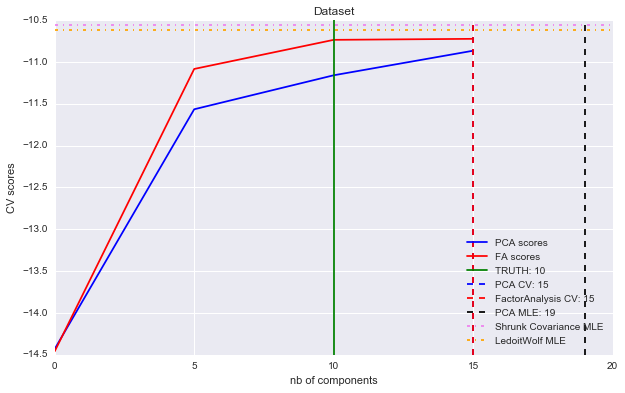

In [15]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV



###############################################################################
# Fit the models
n_samples = trainX.shape[0]
n_features = trainX.shape[1]
rank = 10

n_components = np.arange(0, n_features, 5)  # options for n_components

def compute_scores(X):
    pca = PCA()
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {'shrinkage': shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


for X, title in [(trainX, 'Dataset')]:
    print "Computing scores"
    pca_scores, fa_scores = compute_scores(X)
    print "Computing components (I)"    
    n_components_pca = n_components[np.argmax(pca_scores)]
    print "Computing components (II)"     
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(n_components='mle')
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, 'b', label='PCA scores')
    plt.plot(n_components, fa_scores, 'r', label='FA scores')
    plt.axvline(rank, color='g', label='TRUTH: %d' % rank, linestyle='-')
    plt.axvline(n_components_pca, color='b',
                label='PCA CV: %d' % n_components_pca, linestyle='--')
    plt.axvline(n_components_fa, color='r',
                                label='FactorAnalysis CV: %d' % n_components_fa, linestyle='--')
    plt.axvline(n_components_pca_mle, color='k',
                label='PCA MLE: %d' % n_components_pca_mle, linestyle='--')

    # compare with other covariance estimators
    plt.axhline(shrunk_cov_score(X), color='violet',
                label='Shrunk Covariance MLE', linestyle='-.')
    plt.axhline(lw_score(X), color='orange',
                label='LedoitWolf MLE' % n_components_pca_mle, linestyle='-.')

    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title(title)

plt.show()

explained variance ratio (first 3 components): [ 0.29136902  0.11221087  0.09439307]
(577, 3)


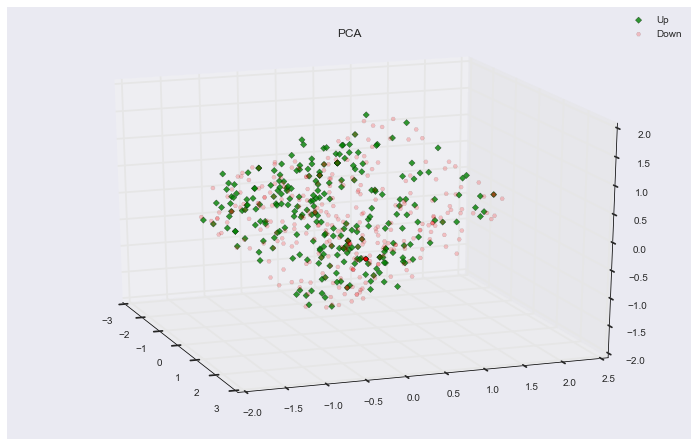

In [12]:
training_dates = Iteration.Iteration('2013-08-19', '2015-12-01')
testing_dates  = Iteration.Iteration('2016-01-04', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)
    
trainX, trainY, testX, testY, cols = ml_dataset.dataset_to_train_using_dates(dataset, trainDates, testDates, binary=False, shiftFeatures=False, shiftTarget=False)
X_r, ratio = features_analysis.pca_analysis(trainX, 3, verbose=True)
print X_r.shape
features_analysis.pca_plot(X_r, trainY, ['Up', 'Down'], 20, -20)

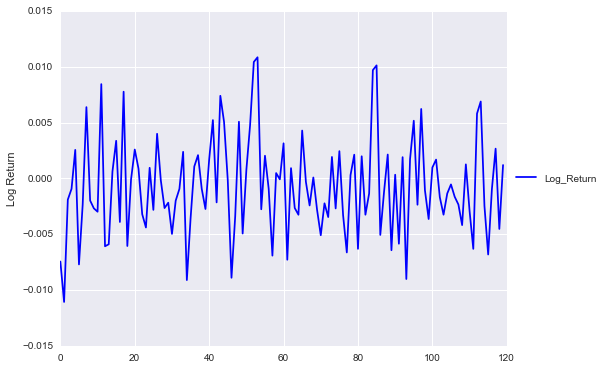

In [19]:
x = [datetime.strptime(d,'%Y-%m-%d').date() for d in INDEX_DJIA['Date'].tolist()]

x_array = np.asarray(x)
nlag = len(x)
range_show = nlag

plt.rcParams["figure.figsize"] = fig_size
pylab.figure(0)
ax = plt.subplot(111)
box = ax.get_position()


ax.plot(INDEX_DJIA['Log_Return'][:120], 'b')
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Log Return')
plt.savefig('/Users/Pablo/Desktop/figure2.png')


In [14]:
N_TREES = 500
SEED = 42


selected_models = [
    "LRC:all_greedy",   
    "SGD:all_greedy",
    
    "LDA:all_greedy", 
    "QDA:all_greedy", 
    
    "SVM:all_greedy", 
    
    "NBG:all_greedy", 
    "NBM:all_greedy", 
    "NBB:all_greedy", 

    "KNN:all_greedy", 
    
    "ABC:all_greedy",
    "BGC:all_greedy",
    "GBC:all_greedy", 
    "RFC:all_greedy",
    "ETC:all_greedy"
]

# Create the models on the fly
models = []
for item in selected_models:
    model_id, data_set = item.split(':')
    model = {'LRC':linear_model.LogisticRegression,
             'SGD':linear_model.SGDClassifier,
             
             'LDA':discriminant_analysis.LinearDiscriminantAnalysis,
             'QDA':discriminant_analysis.QuadraticDiscriminantAnalysis,
             
             'SVM':svm.SVC,
            
             'NBG':naive_bayes.GaussianNB,
             'NBM':naive_bayes.MultinomialNB,
             'NBB':naive_bayes.BernoulliNB,
             
             "KNN":neighbors.KNeighborsClassifier,

             'ABC': ensemble.AdaBoostClassifier,
             'BGC': ensemble.BaggingClassifier,             
             'GBC': ensemble.GradientBoostingClassifier,
             'RFC': ensemble.RandomForestClassifier,
             'ETC': ensemble.ExtraTreesClassifier        
            }[model_id]()
    models.append((model, data_set))

grid_search = True
## Set params
for model, feature_set in models:
    model.set_params(**classifier_utils.find_params(model, feature_set, trainX, trainY, grid_search))

LRC
all_greedy
SGD
all_greedy
LDA
all_greedy
QDA
all_greedy
SVM
all_greedy
NBG
all_greedy
NBM
all_greedy
NBB
all_greedy
KNN
all_greedy
ABC
all_greedy
BGC
all_greedy
GBC
all_greedy
RFC
all_greedy
ETC
all_greedy
using params LR:all_greedy: {'penalty': u'l2', 'C': 1.5, 'random_state': 42}
using params SGDC:all_greedy: {'loss': 'log'}
using params LDA:all_greedy: {}
using params QDA:all_greedy: {}
found params (SVC:all_greedy > 0.5250): {'kernel': 'linear', 'C': 5, 'decision_function_shape': 'ovo', 'degree': 3, 'shrinking': False}
using params GNB:all_greedy: {}
found params (MNB:all_greedy > 0.5297): {'alpha': 1.0, 'fit_prior': True}
found params (BNB:all_greedy > 0.5574): {'alpha': 0.0, 'fit_prior': True}
found params (KNC:all_greedy > 0.4847): {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 3}
found params (ABC:all_greedy > 0.5789): {'n_estimators': 5, 'learning_rate': 0.08}
found params (BC:all_greedy > 0.4733): {'n_estimators': 10}
found params (GBC:all_greed

In [15]:
################
##  Stacking  ##
################
clf = Stacking.Stacking(models, stack=True, fwls=False,
                           model_selection=True)

###  Metrics
print("computing cv score")
mean_auc = 0.0
iter_ = 1
for i in range(iter_):        
    cv_preds = clf.fit_predict(trainY, trainX, testX, testY, show_steps=True)

    fpr, tpr, _ = metrics.roc_curve(testY, cv_preds)
    roc_auc = metrics.auc(fpr, tpr)
    print "AUC (fold %d/%d): %.5f" % (i + 1, iter_, roc_auc)
    mean_auc += roc_auc

    print "Mean AUC: %.5f" % (mean_auc/iter_)
    
#dat = '2016-04-20'
#dataset.Date[dataset.Date == dat].index[0]

computing cv score
> AUC: 0.6858 (0.6858, 0.3142, 0.0000) [LR:all_greedy]
> AUC: 0.5527 (0.6456, 0.3673, 0.0000) [SGDC:all_greedy]
> AUC: 0.6793 (0.6449, 0.3580, 0.0000) [LDA:all_greedy]
> AUC: 0.5258 (0.6155, 0.4419, 0.0000) [QDA:all_greedy]
> AUC: 0.3135 (0.6162, 0.4419, 0.0000) [SVC:all_greedy]
> AUC: 0.6126 (0.6076, 0.5129, 0.0000) [GNB:all_greedy]
> AUC: 0.6363 (0.6176, 0.4254, 0.0000) [MNB:all_greedy]
> AUC: 0.6176 (0.6083, 0.5208, 0.0000) [BNB:all_greedy]
> AUC: 0.5395 (0.5990, 0.4950, 0.0000) [KNC:all_greedy]
> AUC: 0.6894 (0.6047, 0.5925, 0.0000) [ABC:all_greedy]
> AUC: 0.5423 (0.6076, 0.5825, 0.0000) [BC:all_greedy]
> AUC: 0.5674 (0.6255, 0.5581, 0.0000) [GBC:all_greedy]
> AUC: 0.6248 (0.6298, 0.5273, 0.0000) [RFC:all_greedy]
> AUC: 0.6083 (0.6298, 0.5280, 0.0000) [ETC:all_greedy]
- best subset auc (7 models): 0.6772 > [0, 2, 4, 6, 9, 12, 13]
- best subset auc (8 models): 0.6621 > [0, 2, 4, 5, 6, 9, 12, 13]
- best subset auc (9 models): 0.6528 > [0, 2, 5, 6, 7, 9, 11, 12, 13]

In [213]:

trainingPeriodList = [365, 365*2,365*3]
testingPeriodList = [1,5,10,30,40,40]
stepList = [100, 200, 300, 400]

for trainingPeriod in trainingPeriodList:
    for testingPeriod in testingPeriodList:
        for step in stepList:

            print "#######################################"
            print "\t Training period %s" % (trainingPeriod)
            print "\t Testing period %s" % (testingPeriod)
            print "\t Step %s" % (step)
            print "#######################################\n"

            init = trainingPeriod + testingPeriod
            match = 0
            missmatch = 0
            
            for index in range(init,dataset.shape[0], step):


                trainDates = []
                testDates = []
                trainDates.append(index - trainingPeriod - testingPeriod)
                trainDates.append(index - testingPeriod)
                testDates.append(index -  testingPeriod + 1)
                testDates.append(index)

                #print "%s %s %s %s" % (trainDates[0], trainDates[1], testDates[0], testDates[1])

                #print "==========================="
                #print "Iteration %s" % (i)
                #print "Training: from %s to %s" % (dataset.Date[trainDates[0]], dataset.Date[trainDates[1]])
                #print "Testing: from %s to %s" % (dataset.Date[testDates[0]], dataset.Date[testDates[1]])

                trainX, trainY, testX, testY, cols = ml_dataset.dataset_to_train_using_dates(dataset, trainDates, testDates, binary=False, shiftFeatures=False, shiftTarget=False)
                #print "%s %s %s %s" % (trainX.shape,trainY.shape,testX.shape,testY.shape)

                ## SVM
                scv = svm.SVC(kernel='rbf')
                scv.fit(trainX, trainY)
                predictions = scv.predict(testX)
                
 
                
                if testY[testingPeriod-1] == predictions[testingPeriod-1]: 
                    match = match + 1
                else: 
                    missmatch = missmatch + 1  

                #print scv.score(testX, testY)
                #print metrics.classification_report(testY, scv.predict(testX))
                #if testingPeriod > 1:     print metrics.roc_auc_score(testY, scv.predict(testX))
            print "%.2f hit " % (float(match)/(match+missmatch))



#######################################
	 Training period 1095
	 Testing period 1
	 Step 10
#######################################

0.60 hit 


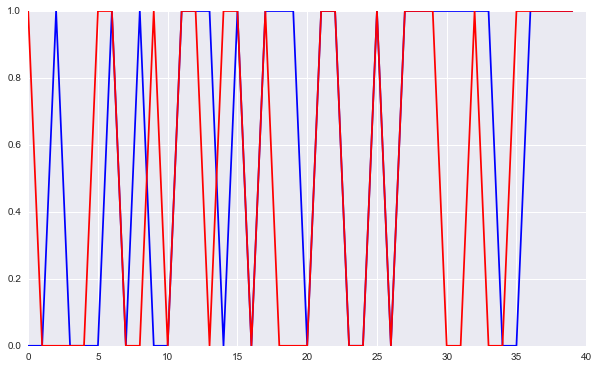

In [85]:
cv_preds = prediction
cv_preds[cv_preds >= 0.5] = 1
ones = np.where(cv_preds == 1)
cv_preds[cv_preds < 0.5] = 0
zeros = np.where(cv_preds == 0)

plt.figure()
plt.plot(cv_preds[0:40], c='blue')
plt.plot(testY[0:40], c='red')
plt.show()

In [49]:
from sklearn import neighbors
#svc = neighbors.KNeighborsClassifier()
#svc = svm.SVC(decision_function_shape='ovr')
svc = ensemble.RandomForestClassifier(n_estimators=200)

svc.fit(trainX, trainY)
prediction = svc.predict(testX)
fpr, tpr, _ = metrics.roc_curve(testY, prediction)
print "> AUC: %.4f " % metrics.auc(fpr, tpr)
print "> Score: %.4f " % svc.score(testX, testY)
print metrics.classification_report(testY, prediction)

> AUC: 0.4286 
> Score: 0.7500 
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.86      0.86      0.86         7

avg / total       0.75      0.75      0.75         8



In [20]:
# Support Vector Machine
from sklearn import datasets

# load the iris datasets
dataset = datasets.load_iris()
# fit a SVM model to the data
model = svm.SVC()
model.fit(dataset.data, dataset.target)
print(model)
# make predictions
expected = dataset.target
predicted = model.predict(dataset.data)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print dataset.data.dtype
print dataset.target.dtype

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.96      0.98        50
          2       0.96      1.00      0.98        50

avg / total       0.99      0.99      0.99       150

[[50  0  0]
 [ 0 48  2]
 [ 0  0 50]]
float64
int64


In [31]:
#data_manipulation.write_csv_data(GOLD, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
#data_manipulation.write_csv_data(SILVER, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
#data_manipulation.write_csv_data(PLAT, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
#data_manipulation.write_csv_data(OIL_BRENT, '/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
#data_manipulation.write_csv_data(INDEX_DJIA, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
#data_manipulation.write_csv_data(INDEX_HSI, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
#data_manipulation.write_csv_data(INDEX_IBEX, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
#data_manipulation.write_csv_data(INDEX_N225, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
#data_manipulation.write_csv_data(INDEX_SP500, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')